# Import block

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Lib.tab import tables_side

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_air = pd.read_csv('df_air.csv',index_col=0)

In [4]:
df_covid = pd.read_csv('df_covid.csv', index_col=0)

In [5]:
df_demo = pd.read_csv('df_demo.csv',index_col=0)

# Main data table creation

In [6]:
df_summary = df_covid[['codice_regione', 'denominazione_regione', 'deceduti']]

In [7]:
df_summary = df_summary.merge(df_demo, left_on='denominazione_regione', right_on='denominazione_regione')

In [8]:
df_summary['death%'] = df_summary['deceduti']/df_summary['popolazione']*100

In [9]:
df_air_med = df_air.groupby(['Regione']).agg({'max media annuale (mg/m3)': ['count', 'mean', 'median']})

In [10]:
tables_side(titolo='Comparison between',
            tabs=[df_summary.sort_values(by='death%', ascending=False), df_air_med.sort_values(by=('max media annuale (mg/m3)', 'median'), ascending=False)],
            tabslabel=['Summary COVID ord by Death%','Summary Air Pollution'])

<b>Adesso ho due dataframe:</b>
* df_summary che contiene la lista delle regione, i deceduti e i deceduti in proporzione alla popolazione (più altri dati come popolazione e id regione
* df_air_med che contiene i valori di inquinamento dell'aria per regione, ho il calcolo della media e della mediana dei valori

Il mio obiettivo sarà riunire questi dati in un unico dataframe, per comodità accorperò tutto in <b>df_summary</b>, per l'inquinamento terrò solo la colonna della mediana

In [11]:
df_summary = df_summary.sort_values(by='death%', ascending=False).merge(df_air_med, left_on='denominazione_regione',right_on='Regione')
df_summary = df_summary.iloc[:,[0,1,2,3,4,7]]
df_summary.columns = ['codice_regione',
               'denominazione_regione',
                            'deceduti',
                         'popolazione',
                              'death%',
                     'air_poll_median']

In [12]:
df_summary.head(3)

,codice_regione,denominazione_regione,deceduti,popolazione,death%,air_poll_median
0,3,Lombardia,5944,10060574,0.059082,27.0
1,2,Valle d'Aosta,41,125666,0.032626,12.0
2,8,Emilia Romagna,1344,4459477,0.030138,18.5


In [13]:
df_covid_complete = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

In [14]:
list_Regions = df_demo.denominazione_regione
dfCVprop = df_covid_complete[['data', 'denominazione_regione', 'deceduti']]

In [15]:
for i in list_Regions:
    dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti'] = dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti']/df_demo[df_demo.denominazione_regione==i]['popolazione'].values*100

In [16]:
df_main = dfCVprop.pivot_table(index='denominazione_regione', columns='data', values='deceduti').transpose()

# Conclusion
Adesso possiedo 4 tabelle di dati:
* <b>df_summary</b>: che contiene i dati delle regioni,riguardanti l'inquinamento dell'aria e dei morti in percentuale alla popolazione ('codice_regione', 'denominazione_regione', 'deceduti', 'popolazione', 'death%', 'air_poll_median')
* <b>df_covid_complete</b>: dataframe completo dal sito github della Protezione Civile, ha tutti le colonne originali
* <b>dfCVprop</b>: datateset di <b>df_covid_complete</b> da cui sono stati estrapolati solamente i dati relativi dalla data di rilevazione, regione e deceduti che sono stati normalizzati in base alla popolazione della regione
* <b>df_main</b>: semplicemente la tabella pivot del dataframe <b>dfCVprop</b> come colonne ha le regioni e come index ha la data delle rilevazioni, la tengo per comodità

# Data Exploration

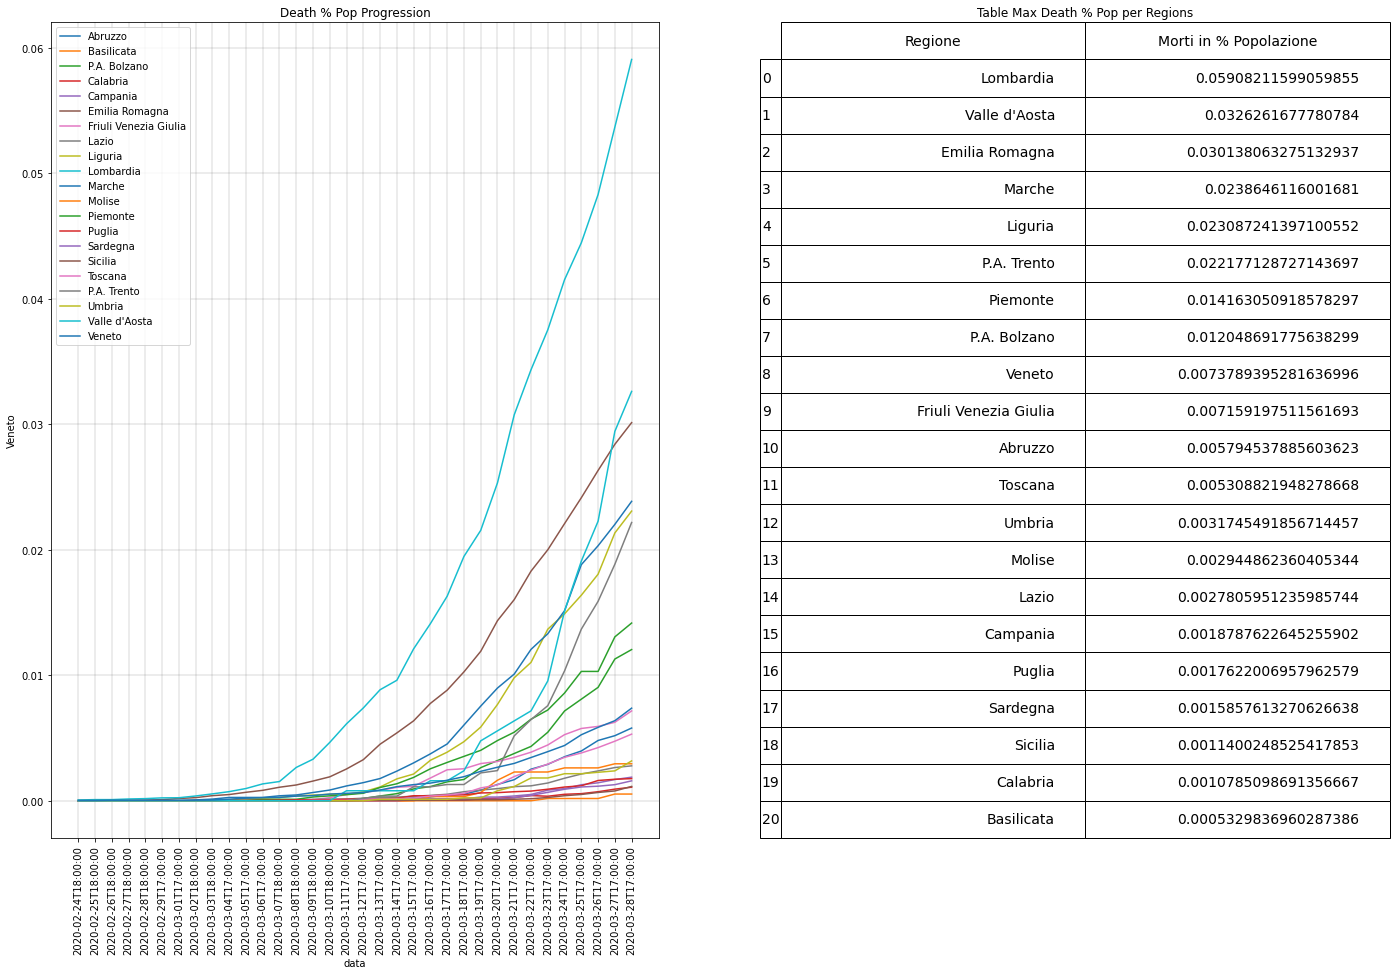

In [17]:
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(121)

for i  in list_Regions:
    ax1=sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i)
ax1.grid(color='gray', linestyle='-', linewidth=0.3)
ax1.legend()
plt.xticks(rotation=90)
plt.title('Death % Pop Progression')

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
plt.title('Table Max Death % Pop per Regions')

mpl_table = ax2.table(cellText = df_summary.iloc[:,[1,4]].sort_values(by='death%',ascending=False).values, rowLabels = df_summary.iloc[:,[1,4]].index, bbox=bbox, colLabels=['Regione','Morti in % Popolazione'],)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [18]:
heatmapshow = df_summary[['denominazione_regione',
                                       'deceduti',
                                         'death%',
                                    'popolazione',
                                'air_poll_median']].corr()


In [19]:
heatmapshow

,deceduti,death%,popolazione,air_poll_median
deceduti,1.000000,0.794909,0.720099,0.540927
death%,0.794909,1.000000,0.370823,0.279878
popolazione,0.720099,0.370823,1.000000,0.802277
air_poll_median,0.540927,0.279878,0.802277,1.000000


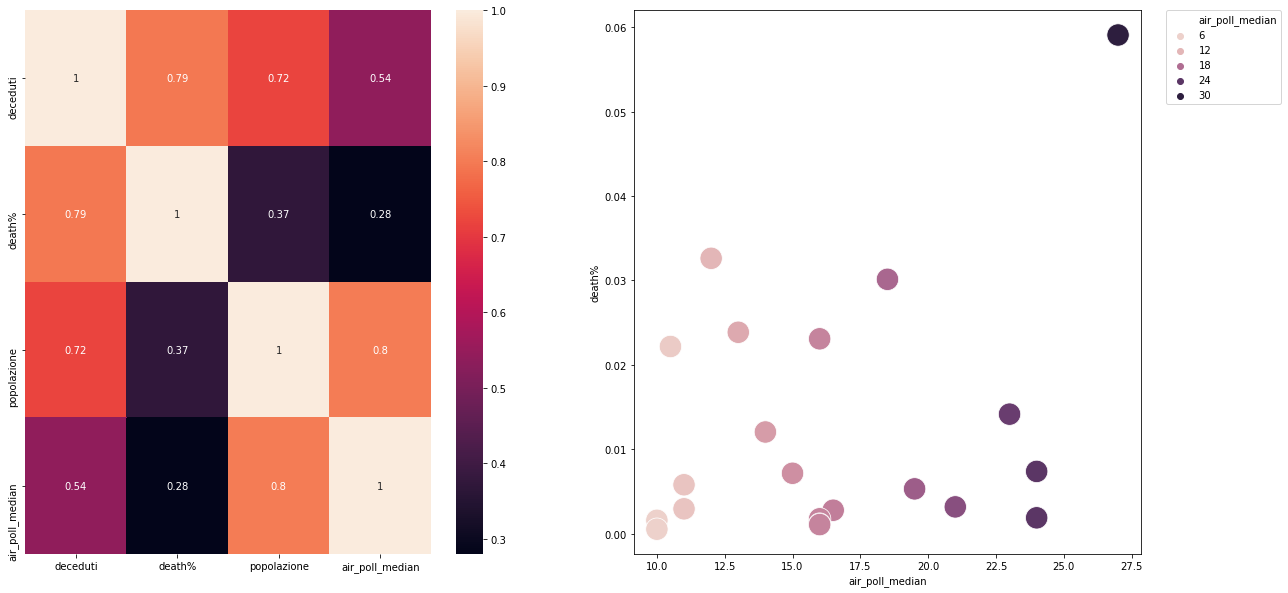

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(122)
sns.scatterplot(x=df_summary.iloc[:,5], y= df_summary['death%'], data=df_summary, hue='air_poll_median', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(121)
sns.heatmap(heatmapshow, annot=True)

In [21]:
pivtable = df_covid_complete.pivot_table(index='denominazione_regione', columns='data', values='deceduti')

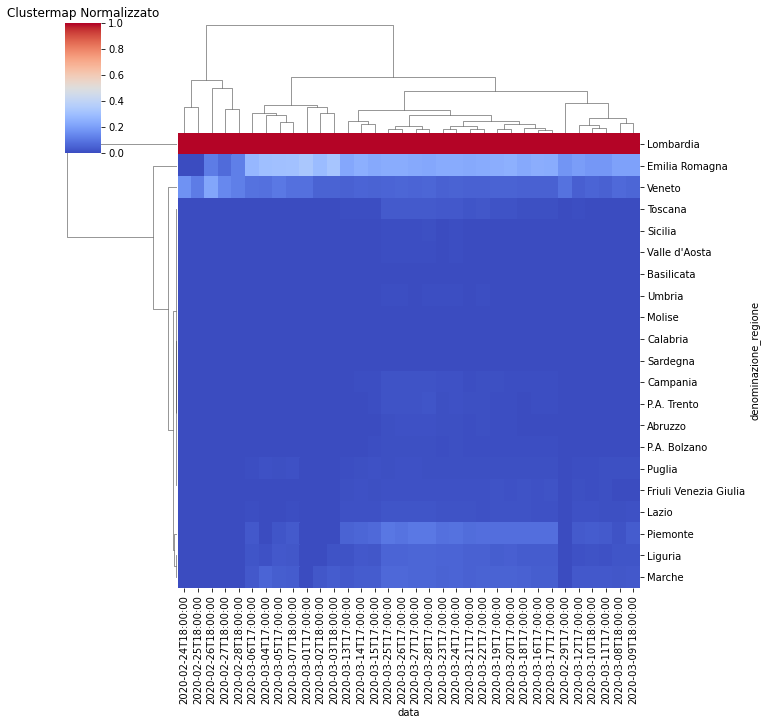

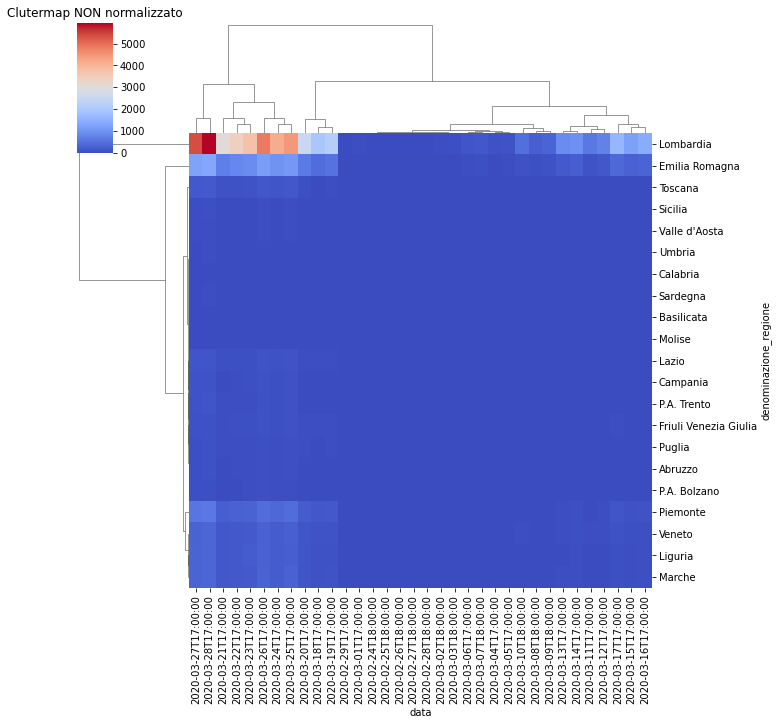

In [22]:
sns.clustermap(pivtable, cmap='coolwarm', standard_scale=1)
plt.title('Clustermap Normalizzato')

sns.clustermap(pivtable, cmap='coolwarm')
plt.title('Clutermap NON normalizzato')
plt.show()

Text(0.5, 1.0, 'Clustermap Normalizzato')

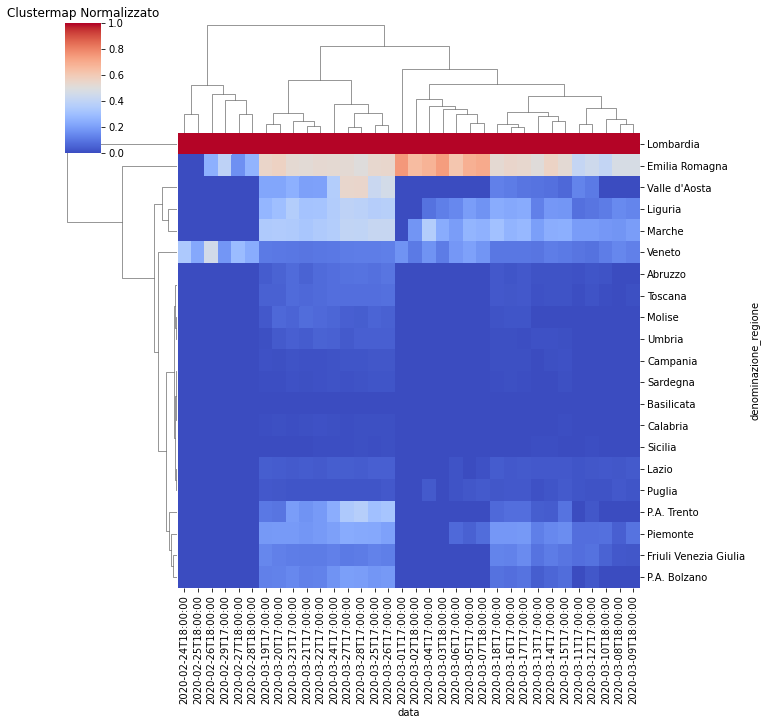

In [23]:
import matplotlib.gridspec
i='Emilia Romagna'
sns.clustermap(df_main.transpose(), cmap='coolwarm', standard_scale=1, figsize=(10,10))
plt.title('Clustermap Normalizzato')

In [24]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania', 'Molise']

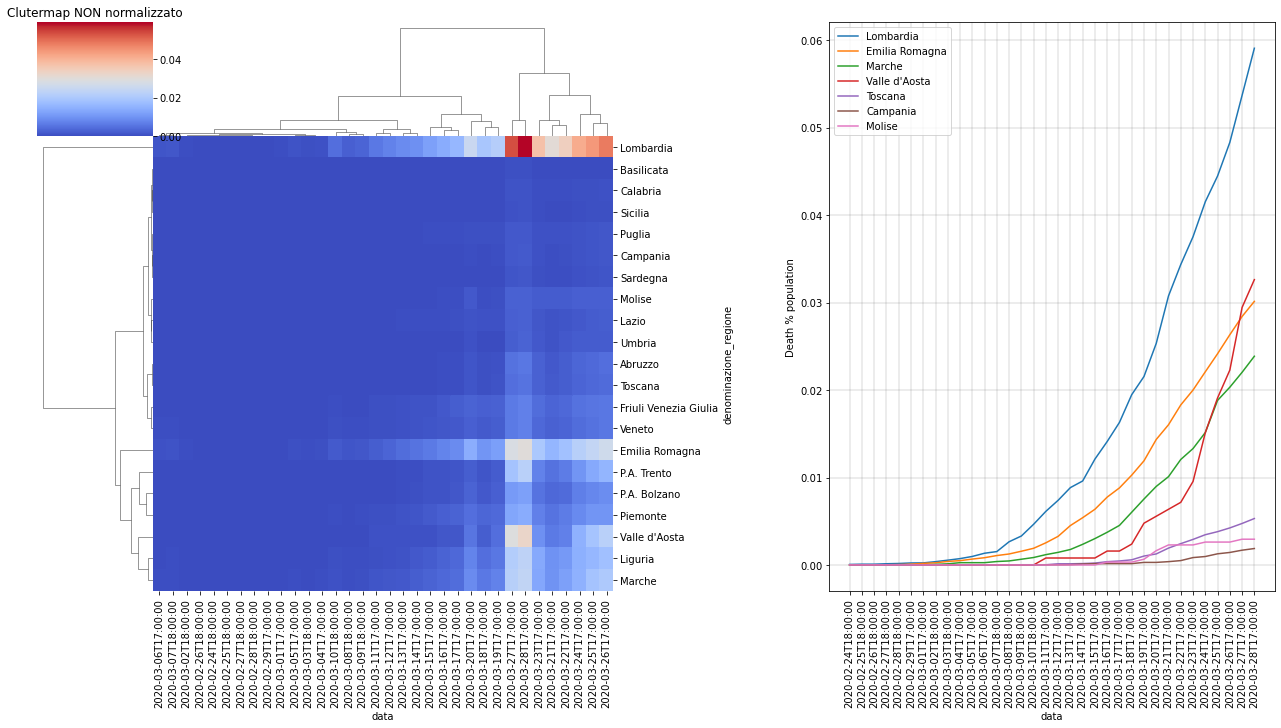

In [25]:
g = sns.clustermap(df_main.transpose(), cmap='coolwarm',figsize=(20,10))
g.gs.update(left=0.05, right=0.45)
plt.title('Clutermap NON normalizzato')
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
for i in l:
    sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i, ax=ax2)
plt.ylabel('Death % population')
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.xticks(rotation=90)
plt.legend(loc='upper left')


plt.show()